In [59]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
%matplotlib notebook
import torch.nn as nn, timeit, torch, pystan as ps
from time import time
import matplotlib.pyplot as plt
from pylab import plot, show, legend

In [2]:
sm_refpoints = ps.StanModel(file="nn_refpoints_normalizedX.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_40e141ac92dec7bc34b02b531dcc6997 NOW.


In [3]:
M = 1000
X = 10*npr.rand(2,M)
Y = np.zeros((3,M))
Y[0] = np.cos(X[0])*np.cos(X[1])
Y[1] = np.cos(X[0])*np.sin(X[1])
Y[2] = np.sin(X[0])

idx = Y[2]>0
Y = Y[:,idx]
X = X[:,idx]
Y += 0.1*npr.rand(*np.shape(Y))
Nobs = np.shape(X)[1]

In [4]:
n_ref = 100
ref_points = npr.choice(Nobs,n_ref,replace=False)
train = np.setdiff1d(np.arange(Nobs), ref_points)
Y_ref = Y[:,ref_points]
X_ref = X[:,ref_points]
Y_train = Y[:,train]

In [5]:
np.shape(X_ref)

(2, 100)

In [6]:
for i in range(np.shape(X)[0]) :
    X_ref[i] /= (Nobs/n_ref)*np.linalg.norm(X_ref[i])

<IPython.core.display.Javascript object>


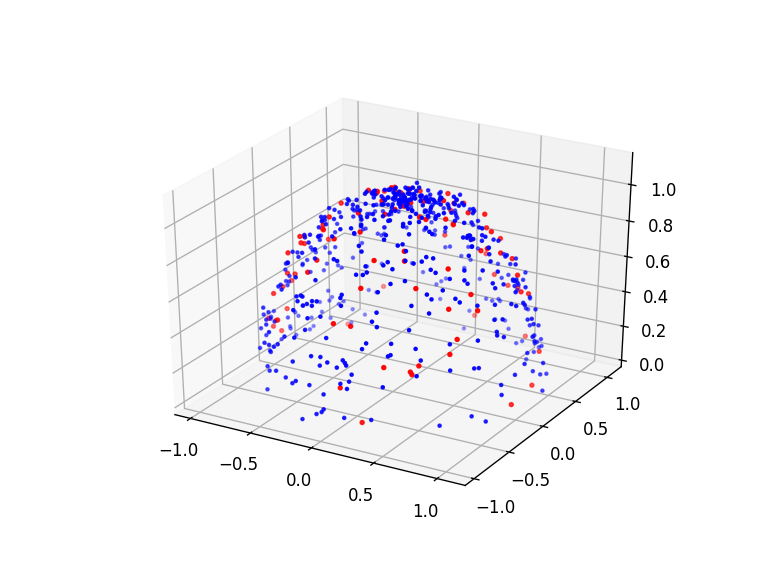

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=Y_train[0], ys=Y_train[1], zs=Y_train[2], zdir='z', s=3, c=None, depthshade=True, color="blue")
ax.scatter(xs=Y_ref[0], ys=Y_ref[1], zs=Y_ref[2], zdir='z', s=5, c=None, depthshade=True, color="red")
plt.show()

In [8]:
data_refpoints = dict(Nobs=Nobs, 
                      in_dim=np.shape(X)[0], 
                      out_dim=np.shape(Y)[0], 
                      hidden_dim=50,
                      n_ref=n_ref,
                      y=Y_train.transpose(), 
                      y_ref=Y_ref.transpose(),
                      X_ref=X_ref.transpose())

In [9]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit_refpoints = sm_refpoints.sampling(data=data_refpoints, thin=1, n_jobs=8,chains=8,
                                      init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_refpoints);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


448.66 minutes to run
Inference for Stan model: anon_model_40e141ac92dec7bc34b02b531dcc6997.
8 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X_normalized[1,1]  -9.7e-3  4.6e-3   0.03  -0.06  -0.03  -0.01 8.8e-3   0.04     32   1.11
X_normalized[2,1]    -0.02  1.1e-3   0.02  -0.06  -0.03  -0.02-4.7e-3   0.03    413   1.04
X_normalized[1,2]  -4.1e-4  1.1e-3   0.02  -0.05  -0.02-2.2e-4   0.02   0.05    491   1.03
X_normalized[2,2]    -0.01  9.3e-4   0.02  -0.06  -0.03-9.8e-3 4.3e-3   0.03    563   1.02
X_normalized[1,3]   2.2e-3    0.02   0.05  -0.09  -0.03 6.8e-3   0.04   0.08      6   1.93
X_normalized[2,3]    -0.06  8.8e-3   0.03  -0.11  -0.08  -0.06  -0.04   0.01     12   1.28
X_normalized[1,4]     0.02  5.1e-3   0.03  -0.04-9.0e-4   0.02   0.04   0.07     34   1.13
X_normalized[2,4]     0.05  1.4e-3   0.02-8.7e-4   0.04   0.05 

In [10]:
trace = fit_refpoints.extract()
n_samples = np.shape(trace['X'])[0]
n_latent = np.shape(trace['X'])[1]

In [12]:
pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for i in range(10) :
    for j in range(10) :
        for k in range(n_samples) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['X'][k,i]-trace['X'][k,j])

<IPython.core.display.Javascript object>


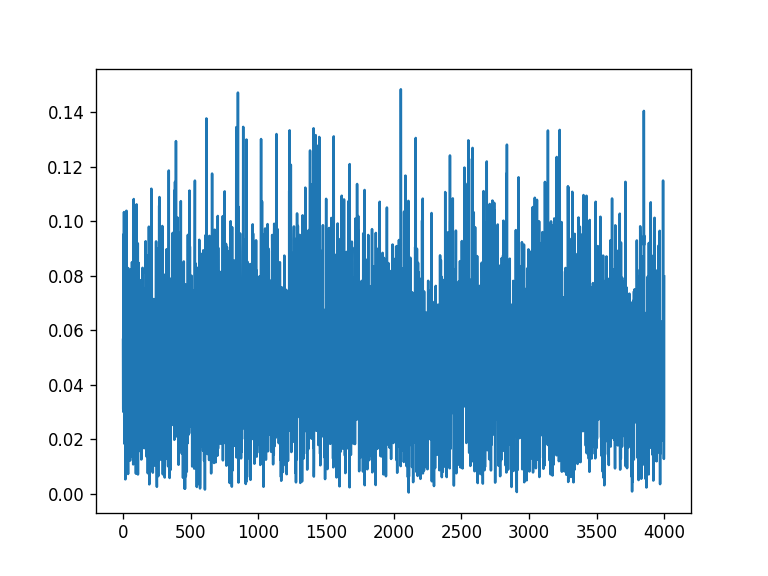

In [16]:
plt.plot(pw_dist_matrix[9,5]);

### Local linear embedding for reference points:

In [23]:
embedding = LocallyLinearEmbedding(n_components=2,n_neighbors=10)
Y_embedded = embedding.fit_transform(Y.transpose()).transpose()

In [33]:
train = np.setdiff1d(np.arange(Nobs), ref_points)
Y_ref = Y[:,ref_points]
X_ref = Y_embedded[:,ref_points]
Y_train = Y[:,train]

In [36]:
data_refpoints = dict(Nobs=Nobs, 
                      in_dim=np.shape(X)[0], 
                      out_dim=np.shape(Y)[0], 
                      hidden_dim=50,
                      n_ref=np.shape(Y_ref)[1],
                      y=Y_train.transpose(), 
                      y_ref=Y_ref.transpose(),
                      X_ref=X_ref.transpose())

In [37]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit_refpoints_lle = sm_refpoints.sampling(data=data_refpoints, thin=1, n_jobs=8,chains=8,
                                      init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_refpoints);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


455.45 minutes to run
Inference for Stan model: anon_model_40e141ac92dec7bc34b02b531dcc6997.
8 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X_normalized[1,1]  -9.7e-3  4.6e-3   0.03  -0.06  -0.03  -0.01 8.8e-3   0.04     32   1.11
X_normalized[2,1]    -0.02  1.1e-3   0.02  -0.06  -0.03  -0.02-4.7e-3   0.03    413   1.04
X_normalized[1,2]  -4.1e-4  1.1e-3   0.02  -0.05  -0.02-2.2e-4   0.02   0.05    491   1.03
X_normalized[2,2]    -0.01  9.3e-4   0.02  -0.06  -0.03-9.8e-3 4.3e-3   0.03    563   1.02
X_normalized[1,3]   2.2e-3    0.02   0.05  -0.09  -0.03 6.8e-3   0.04   0.08      6   1.93
X_normalized[2,3]    -0.06  8.8e-3   0.03  -0.11  -0.08  -0.06  -0.04   0.01     12   1.28
X_normalized[1,4]     0.02  5.1e-3   0.03  -0.04-9.0e-4   0.02   0.04   0.07     34   1.13
X_normalized[2,4]     0.05  1.4e-3   0.02-8.7e-4   0.04   0.05 

In [39]:
trace_lle = fit_refpoints_lle.extract()
n_samples = np.shape(trace_lle['X'])[0]
n_latent = np.shape(trace_lle['X'])[1]

In [45]:
np.shape(trace_lle['X_normalized'])

(4000, 2, 534)

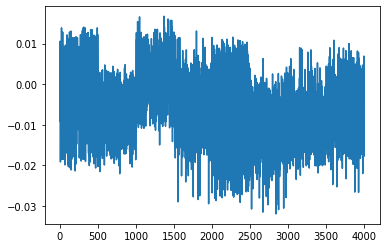

In [61]:
%matplotlib inline 
plt.plot(trace_lle['X_normalized'][:,0,10])

In [65]:
np.sum(trace_lle['X_normalized'][:,0,:]**2,axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
L2_errors = np.zeros(n_samples)
for i in range(n_samples) :
    y_pred = 

In [ ]:
tanh(X[n,:]*weights_1 + bias_1)*weights_2

In [84]:
i = 0
np.mean(np.sum(((np.matmul(np.tanh(np.matmul(trace_lle['X'][i],trace_lle['weights_1'][i])+trace_lle['bias_1'][i]),
          trace_lle['weights_2'][i]) + trace_lle['bias_2'][i]).transpose() - Y_train)**2,axis=0))

0.02597618905654567

In [104]:
def L2_loss(Y, X, weights_1, bias_1, weights_2, bias_2) :
    Y_pred = np.matmul(np.tanh(np.matmul(X,weights_1)+bias_1), weights_2) + bias_2
    return np.mean(np.sum((Y-Y_pred)**2,axis=1))

In [113]:
loss = np.zeros(n_samples)
for i in trange(n_samples) :
    loss[i] = L2_loss(Y_train.transpose(), trace_lle['X'][i], trace_lle['weights_1'][i], 
                      trace_lle['bias_1'][i], trace_lle['weights_2'][i], trace_lle['bias_2'][i]) \
                / trace['error_sigma2'][i]

100%|██████████| 4000/4000 [00:02<00:00, 1720.11it/s]


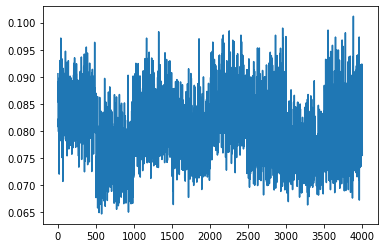

In [114]:
plt.plot(loss)

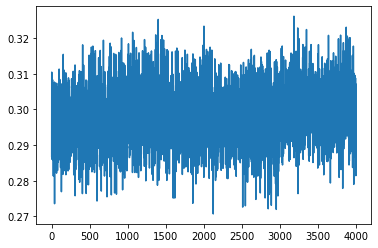

In [110]:
plt.plot(trace['error_sigma2'])

In [46]:
pw_dist_matrix_lle = np.zeros((n_latent,n_latent,n_samples))
for i in range(10) :
    for j in range(10) :
        for k in range(n_samples) :
            pw_dist_matrix_lle[i,j,k] = np.linalg.norm(trace_lle['X_normalized'][k,:,i]-
                                                       trace['X_normalized'][k,:,j])

<IPython.core.display.Javascript object>


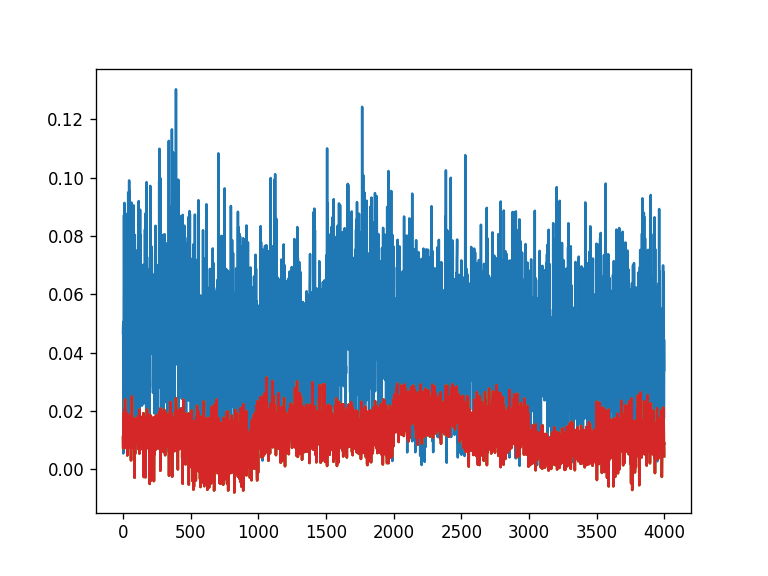

In [47]:
plt.plot(pw_dist_matrix_lle[1,5]);